# Autoencoders

Autoencoders (AEs) are a type of neural network architecture designed to learn efficient data representations, primarily for the purpose of dimensionality reduction or feature learning, making AEs able to find a compressed representation of the input data such as image, video, text, speech, etc. By doing this, the autoencoder learns to extract the most important features of the input data and represent it in a lower-dimensional space. This compressed representation, also known as the "latent space", is typically of lower dimensionality than the original input data, which allows for more efficient storage and processing of the data. The goal of an autoencoder is to learn a compressed representation of the input data and use that compressed representation to reconstruct the original input data as closely as possible, while minimizing the reconstruction error.

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

In [2]:
# setting the device
device= 'cuda' if torch.cuda.is_available() else 'cpu'

# Data Processing

The pixel values fall in the range of 0 to 255. As a preprocessing step, these pixel values are normalized to fall from 0 to 1. This is achieved by dividing each pixel value by 255. This normalization helps in faster and more stable convergence during training.

In [3]:
# calling the dataset
from tensorflow.keras.datasets import mnist

# access the training and test data
(Xtr_raw, Ytr_raw), (Xte_raw, Yte_raw)= mnist.load_data()

# data reformating - adding a channel dimension
Xtr_raw= np.expand_dims(Xtr_raw, 1) # Grayscale images have 1 channel
Xte_raw= np.expand_dims(Xte_raw, 1)

# convert data to float32
Xtr_raw= Xtr_raw.astype(np.float32)
Xte_raw= Xte_raw.astype(np.float32)


IMG_MAXVAL= 255.0

# normalizing the training data
Xtr_raw /= IMG_MAXVAL

# normalizing the test data
Xte_raw /= IMG_MAXVAL


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [4]:
# converting data to pytorch type
Xtr= torch.tensor(Xtr_raw, requires_grad=True).to(device)
Ytr= torch.tensor(Ytr_raw).to(device)
Xte= torch.tensor(Xte_raw, requires_grad=True).to(device)
Yte= torch.tensor(Yte_raw).to(device)

# transforming labels from numbers to one-hot vectors of length 10
Ytr= F.one_hot(Ytr.type(torch.int64), num_classes=10).type(torch.float32)
Yte= F.one_hot(Yte.type(torch.int64), num_classes=10).type(torch.float32)

# creating a dev dataset from training data
tr_size= int(0.8*Xtr.shape[0])

Xdev= Xtr[tr_size:]
Ydev= Ytr[tr_size:]

Xtr= Xtr[:tr_size]
Ytr= Ytr[:tr_size]

print(f'Shape of training: Xtr - {Xtr.shape}, Ytr - {Ytr.shape}')
print(f'Shape of dev data: Xdev - {Xdev.shape}, Ydev - {Ydev.shape}')
print(f'Shape of test data: Xte - {Xte.shape}, Yte - {Yte.shape}')

Shape of training: Xtr - torch.Size([48000, 1, 28, 28]), Ytr - torch.Size([48000, 10])
Shape of dev data: Xdev - torch.Size([12000, 1, 28, 28]), Ydev - torch.Size([12000, 10])
Shape of test data: Xte - torch.Size([10000, 1, 28, 28]), Yte - torch.Size([10000, 10])


# Autoencoders (AEs) architecture

An Autoencoder consists of two main types of networks parts: an encoder and a decoder. The encoder takes in an input data sample and maps it to a lower-dimensional latent representation, also known as a code or bottleneck because it compresses the input data while retaining its important features. The size of the bottleneck, also known as the encoding dimension, is a hyperparameter that is set before the training of the model and it's usually smaller than the size of the original input data. The decoder then takes this lower-dimensional representation and maps it back to the original input data space, reconstructing the input data as closely as possible. However, it is important to note that this reconstruction is lossy, meaning that the reconstructed output may not be an exact copy of the original input. This is because the autoencoder is trained to minimize the reconstruction error, which measures the difference between the original input and the reconstructed output. Therefore, the reconstructed output may have some loss of information compared to the original input.

**NOTE:** I will use a CNN-based architecture here, but AEs are a more general concept.

In [5]:
class Encoder(nn.Module):
    """
    Define the Encoder module.
    """

    def __init__(self, embed_dim, image_size, input_chs, hidden_chs, output_chs,
                 kernels=3, paddings=1, max_pools=2) -> None:
        super(Encoder, self).__init__()
        # convolutional layers
        self.conv_in= nn.Conv2d(input_chs, hidden_chs[0], kernels, padding=paddings)
        self.m_pool1= nn.MaxPool2d(max_pools)
        self.activ1= nn.ReLU()

        self.conv_hn= nn.Conv2d(hidden_chs[0], hidden_chs[1], kernels, padding=paddings)
        self.m_pool2= nn.MaxPool2d(max_pools)
        self.activ2= nn.ReLU()

        self.conv_out= nn.Conv2d(hidden_chs[1], output_chs, kernels, padding=paddings)
        self.m_pool3= nn.MaxPool2d(max_pools)
        self.activ3= nn.ReLU()

        self.flatten= nn.Flatten()
        # compute the flattened size after convolutions
        self.flat_size= ((image_size//(max_pools**3))**2) * output_chs
        # fully connected layer to create embeddings
        self.fc_out= nn.Linear(self.flat_size, embed_dim)

        for p in self.parameters():
            if p.dim()> 1:
                nn.init.kaiming_normal_(p, nonlinearity='relu')


    def forward(self, x):
        z= self.activ1(self.m_pool1(self.conv_in(x)))
        z= self.activ2(self.m_pool2(self.conv_hn(z)))
        z= self.activ3(self.m_pool3(self.conv_out(z)))
        z= self.fc_out(self.flatten(z))

        return z  # outputs an encoded latent space


Upsampling and convolution transpose:

https://www.youtube.com/watch?v=ByjaPdWXKJ4 17:00min


In [6]:
class Decoder(nn.Module):
    """
    Define the Decoder module.
    """

    def __init__(self, embed_dim, output_linear,
                 input_chs, hidden_chs, output_chs, kernels=3, paddings=1, strides=2) -> None:
        super(Decoder, self).__init__()
        # fully connected layer to reshape flatten tensor to 2D tensor
        self.fc_in= nn.Linear(embed_dim, output_linear)
        unflat_size= int((output_linear // input_chs)**0.5)
        unflat_dims= torch.Size([input_chs, unflat_size, unflat_size])
        self.make2d= nn.Unflatten(1, unflat_dims)

        # convT layers -- in_channels, out_channels, kernel_size, stride, padding, output_padding
        self.convT_in= nn.ConvTranspose2d(input_chs, input_chs, kernels, strides, paddings, paddings)
        self.activ1= nn.ReLU()
        self.convT_hn= nn.ConvTranspose2d(input_chs, hidden_chs[0], kernels, strides, paddings-1, paddings)
        self.activ2= nn.ReLU()
        self.convT_out= nn.ConvTranspose2d(hidden_chs[0], hidden_chs[1], kernels, strides, paddings, paddings)
        self.activ3= nn.ReLU()
        # final convolutional layer to generate output image
        self.conv_out= nn.Conv2d(hidden_chs[1], output_chs, kernels, padding=paddings)

        for p in self.parameters():
            if p.dim()> 1:
                nn.init.kaiming_normal_(p, nonlinearity='relu')


    def forward(self, z):
        x= self.make2d(self.fc_in(z))
        x= self.activ1(self.convT_in(x))
        x= self.activ2(self.convT_hn(x))
        x= self.activ3(self.convT_out(x))
        x= self.conv_out(x)

        return F.sigmoid(x)  # outputs a decoded image from a latent space


In [ ]:
# https://pyimagesearch.com/2023/07/17/implementing-a-convolutional-autoencoder-with-pytorch/

In [7]:
class Autoencoder(nn.Module):
    """
    Define the Autoencoder (Encoder-Decoder) model.
    """

    def __init__(self, embed_dim, image_size, input_chs, hidden_chs, output_chs,
                 kernels=3, paddings=1, max_pools=2) -> None:
        super(Autoencoder, self).__init__()
        self.embed_dim= embed_dim
        # define the Encoder-Decoder architecture
        self.encoder= Encoder(
            embed_dim, image_size, input_chs, hidden_chs, output_chs, kernels, paddings, max_pools
        )
        dec_input_chs= output_chs
        dec_hidden_chs= hidden_chs[::-1]
        dec_output_chs= input_chs
        dec_strides= max_pools

        self.decoder= Decoder(
            embed_dim, self.encoder.flat_size, dec_input_chs, dec_hidden_chs, dec_output_chs,
            kernels, paddings, dec_strides
        )


    def encode(self, x):
        encoded= self.encoder(x)
        # outputs an encoded latent space
        return encoded


    def decode(self, z):
        decoded= self.decoder(z)
        # outputs a decoded image from a latent space
        return decoded


    def forward(self, x):
        encoded= self.encode(x)
        decoded= self.decode(encoded)

        return encoded, decoded


**NOTE -- Unsupervised learning and Autoencoders:**

https://www.youtube.com/watch?v=ekyBklxwQMU 32:05min

**Unsupervised feature learning:** After training the Autoencoder, we can throw away the decoder, refresh the FC network of at the end of the encoder and fine tune it as as classifier (updating the code to something like the backbone-head archtecture we implemented for SSL).

Therefore, Autoencoders can reconstruct data and can learn features to initialize a supervised model. We can also use them to generate data by learning probability distributions about our data (latent spaces) and how probability distributions can fit together to generate datasets.

In [8]:
# --- encoder defs ---
embed_dim= 64
image_size= Xtr.shape[2]
input_chs= Xtr.shape[1]
hidden_chs= [32,64]
output_chs= 128
kernels= 3
paddings= 1
max_pools= 2

enc_model= Encoder(embed_dim, image_size, input_chs, hidden_chs, output_chs, kernels, paddings,
                   max_pools).to(device)

# Encode a sample image and generate a latent vector
y_enc= enc_model(Xtr[:1])
y_enc.shape

torch.Size([1, 64])

In [9]:
# --- decoder defs ---
embed_dim= y_enc.shape[1]
output_linear= enc_model.flat_size
input_chs= 128
hidden_chs= [64,32]
output_chs= Xtr.shape[1]
kernels= 3
paddings= 1
strides= max_pools

dec_model= Decoder(embed_dim, output_linear,
                   input_chs, hidden_chs, output_chs, kernels, paddings, strides).to(device)

# Decode a latent vector
y_dec= dec_model(y_enc)
y_dec.shape

torch.Size([1, 1, 28, 28])

In [10]:
# --- AE defs ---
embed_dim= 64
image_size= Xtr.shape[2]
input_chs= Xtr.shape[1]
hidden_chs= [32,64]
output_chs= 128
kernels= 3
paddings= 1
max_pools= 2

ae_model= Autoencoder(embed_dim, image_size, input_chs, hidden_chs, output_chs,
                      kernels, paddings, max_pools).to(device)

# Encode a sample image and decode its latent vector
y_en, y_dec= ae_model(Xtr[:1])
y_en.shape, y_dec.shape

(torch.Size([1, 64]), torch.Size([1, 1, 28, 28]))

In [11]:
total_params= sum(p.numel() for p in ae_model.parameters() if p.requires_grad)
print(f'Number of parameters: {total_params}')

ae_model

Number of parameters: 481473


Autoencoder(
  (encoder): Encoder(
    (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (m_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (activ1): ReLU()
    (conv_hn): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (m_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (activ2): ReLU()
    (conv_out): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (m_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (activ3): ReLU()
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc_out): Linear(in_features=1152, out_features=64, bias=True)
  )
  (decoder): Decoder(
    (fc_in): Linear(in_features=64, out_features=1152, bias=True)
    (make2d): Unflatten(dim=1, unflattened_size=torch.Size([128, 3, 3]))
    (convT_in): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=

# Contractive Autoencoders

It is a type of AE where the regularization term is based on the contractive property. The contractive property refers to the fact that Contractive AEs work on the basis that similar inputs should have similar encodings and a similar latent space representation. It means that the latent space should not vary by a huge amount for minor variations in the input. Therefore, a Contractive AE is designed to learn a compressed representation of the input data that is insensitive to small perturbations. As a result, the encoding layer "contracts" the input data into a compressed representation that captures the essential features of the data.

https://medium.com/@ompramod9921/autoencoders-explained-a223a5268618

# Contractive Loss

In the context of machine learning, perturbations refer to small changes or variations made to the input data in order to study the behaviour of a model or to improve its robustness by testing its ability to generalize to slightly different inputs. These perturbations can be intentional or random, and can be applied to different types of data, such as images, text, and numerical data. For example, in the context of image classification, perturbations can be applied to an image by adding small amounts of noise or changing the brightness, contrast, or orientation of the image. By doing so, we can study how the classification model responds to different types of input variations and assess its robustness to different types of noise or image transformations.

This is achieved by adding a penalty term to the loss function that measures the sensitivity of the encoding layer to small changes in the input data. The total loss function of a contractive autoencoder is a combination of two terms: the reconstruction loss ($L_{recon}$) and a regularization term ($\lambda * ||J_f(x)||^2$). The reconstruction loss is the same as in a standard autoencoder and measures the difference between the input and the reconstructed output. The regularization term, on the other hand, penalizes the encoding layer for being too sensitive to small changes in the input data.

The squared Frobenius norm of the Jacobian matrix measures the sensitivity of the encoding layer to small changes in the input data. A higher norm value implies that the encoding layer is more sensitive to input perturbations, and a lower norm value implies that the encoding layer is more robust to input variations. Therefore, minimizing the squared Frobenius norm encourages the encoding layer to learn a more robust representation of the input data.

In [ ]:
class ContractiveAutoencoderLoss(nn.Module):
    """
    Define the contractive autoencoder loss function.
    """

    def __init__(self, penalty_lambda=1e-4) -> None:
        super().__init__()
        self.penalty_lambda= penalty_lambda


    def forward(self, y_pred_enc, y_pred, y_true):
        # calculate the reconstruction loss
        reconstruction_loss_fn= nn.MSELoss()
        reconstruction_loss= reconstruction_loss_fn(y_pred, y_true)

        # calculate the contractive penalty
        y_pred_enc.backward(torch.ones(y_pred_enc.size()).to(device), retain_graph=True)
        # Frobenius norm - the square root of the sum of the squares of all the Jacobian matrix entries
        contractive_penalty= torch.sqrt(torch.sum(torch.pow(y_true.grad, 2)))
        y_true.grad.data.zero_()

        loss= reconstruction_loss + self.penalty_lambda * contractive_penalty

        return loss   # return the total loss


In [ ]:
# https://stackoverflow.com/questions/58249160/how-to-implement-contractive-autoencoder-in-pytorch

# Training the Contractive AE

In practice, L2 loss is not used anymore because the L2 is not quite the right loss for actually learning features.

https://www.youtube.com/watch?v=ekyBklxwQMU 45:00min

In [ ]:
def c_autoencoder_training(model, learning_rate=1e-3, epochs=500, eval_interval=5, batches:bool=True,
                           batch_size=64, shuffle:bool=True, early_stop:bool=True, patience=5, cutoff=1e-9):

    # defining key hyperparamaters explicitly (instead of hyperparamater search)
    if batches:
        epoch_size= math.floor(Xtr.shape[0]/ batch_size)
    else:
        batch_size= Xtr.shape[0]
        epoch_size= 1

    weight_decay=5e-4

    # create a PyTorch optimizer
    optimizer= torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # loss function
    loss_tr_fn= ContractiveAutoencoderLoss().forward
    loss_ev_fn= nn.MSELoss()

    # for decreasing learning rate -- the ReduceLROnPlateau is designed to be used per epoch
    scheduler= ReduceLROnPlateau(optimizer, mode="min", patience=5, factor=0.1, min_lr=1e-6)

    # for early stoping
    patience_count= 0
    previous_loss= 1e10

    # tracking statistics
    train_hist= []
    dev_hist= []
    schedule_hist= []

    # training data indexes
    ix= torch.arange(0, Xtr.shape[0])

    # --- training loop ---
    for epoch in tqdm(range(epochs)):

        batch_loss= []
        batch_schedule= []

        # iterating over all batches
        if shuffle:
            ix= torch.randperm(Xtr.shape[0])[:Xtr.shape[0]]

        for i in range(epoch_size):

            # --- minibatch construction ---
            Xmb= Xtr[ix[(i * batch_size) : ((i+1) * batch_size)]]
            Xmb.retain_grad()

            # --- forward pass and get loss ---
            model.train(True)
            y_enc, y_enc_dec= model(Xmb)
            loss_tr= loss_tr_fn(y_enc, y_enc_dec, Xmb)
            batch_loss.append(loss_tr.item())

            # --- backward pass to calculate the gradients ---
            optimizer.zero_grad()
            loss_tr.backward()

            # --- update the parameters using the gradient ---
            optimizer.step()


        # --- evaluation and track stats ---
        train_hist.append(np.mean(batch_loss))

        if epoch% eval_interval== 0:
            model.train(False)
            with torch.no_grad():
                _, y_enc_dec= model(Xdev)
                loss_dev= loss_ev_fn(y_enc_dec, Xdev)

        dev_hist.append(loss_dev.item())
        schedule_hist.append(scheduler.get_last_lr())
        scheduler.step(train_hist[-1]) # step learning rate scheduler


        # --- early stopping -- calculating loss change ---
        loss_change= np.abs(previous_loss - train_hist[-1])
        # deciding to stop if loss is not decreasing fast enough
        if (early_stop and loss_change< cutoff):
            patience_count += 1

            if patience_count> patience:
                print('\nEarly stopping at epoch {}'.format(epoch))
                model.train(False)
                break
        else:
            patience_count= 0
        # setting current train loss as previous loss
        previous_loss= train_hist[-1]


    return train_hist, dev_hist, schedule_hist


In [ ]:
def eval_autoencoder(model, test_data, loss_fn=nn.MSELoss()):

    model.train(False)
    with torch.no_grad():
        _, y_enc_dec= model(test_data)
        loss_test= loss_fn(y_enc_dec, test_data)

    return loss_test.item()


In [ ]:
# --- reseting the AE model for contractive training ---
ae_model= Autoencoder(embed_dim, image_size, input_chs, hidden_chs, output_chs,
                      kernels, paddings, max_pools).to(device)

train_hist, dev_hist, schedule_hist= c_autoencoder_training(ae_model, learning_rate=1e-3, epochs=30,
                                                            batch_size=250, eval_interval=2, cutoff=1e-4)


100%|██████████| 30/30 [38:57<00:00, 77.92s/it]


In [ ]:
eval_autoencoder(ae_model, Xte)

0.010506288148462772

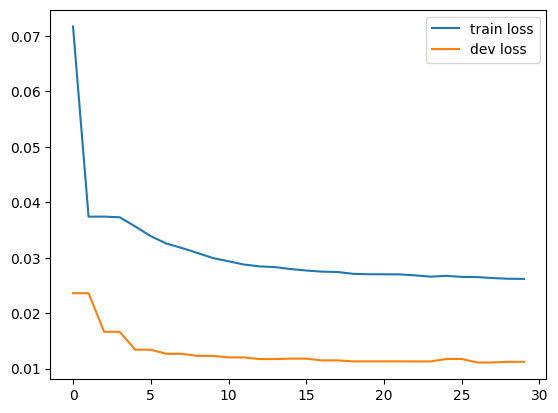

In [ ]:
# ploting
plt.plot(train_hist, label='train loss')
plt.plot(dev_hist, label='dev loss')
plt.legend()
plt.show()

# Inferring the Contractive AE model

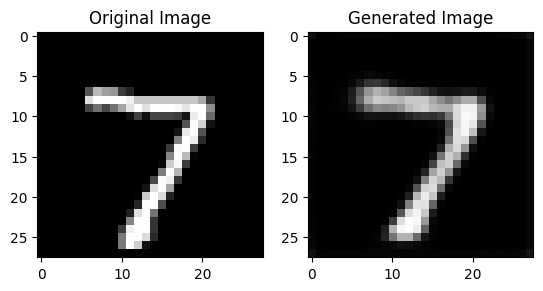

In [ ]:
# Select an image from the test set
img_index= 0
test_img= Xte[img_index:img_index+1]

latent_vector, generated_img= ae_model(test_img)


# Plot the original image and the generated image
plt.subplot(1, 2, 1)
plt.imshow(test_img[0][0].cpu().detach().numpy(), cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(generated_img[0][0].cpu().detach().numpy(), cmap='gray')
plt.title('Generated Image')

plt.show()

# Denoising Autoencoders

In traditional Autoencoders, the goal is to learn a compressed representation that preserves the essential information in the data. However, if the input data is noisy or corrupted, the autoencoder may learn to encode and decode the noise as well, resulting in a poor compressed representation. Denoising autoencoders address this problem by learning to denoise the input data during training.

One approach to encourage an autoencoder to learn a useful representation of data is to keep the code layer small. This forces the model to learn an intelligent representation of the data rather than simply copying the input to the output. Another approach is to add random noise to the input data and train the autoencoder to recover the original, noise-free data. This way the autoencoder can't simply copy the input to its output because the input also contains random noise. This technique is called a denoising autoencoder and helps ensure that the model is subtracting the noise and learning the underlying meaningful features of the data.

The amount and type of noise added can vary depending on the problem being solved. For example, in image denoising tasks, random noise can be added to the pixels of an image to create a noisy version of the image. The noise can be added in various ways, such as Gaussian noise, salt-and-pepper noise, or random pixel dropout. Similarly, in speech denoising tasks, random noise can be added to the audio signal to create a noisy version of the speech.

**Data augmentation by adding Gaussian noise**

In [ ]:
class NoiseAugment:
    """
    A data augmentation module based on adding Gaussian noise to images.
    """

    def __init__(self, sigma=0.1, norm=False) -> None:
        self.sigma= sigma
        self.norm = norm


    def __call__(self, x):
        # Generate Gaussian noise
        noise= torch.randn(size=x.shape).to(device)
        if self.norm:
            noise -= noise.amin(dim=(1,2,3), keepdim=True)
            noise /= noise.amax(dim=(1,2,3), keepdim=True)

        # Clip the images to be between 0 and 1
        return torch.clip((x + (self.sigma * noise)), min=0.0, max=1.0)


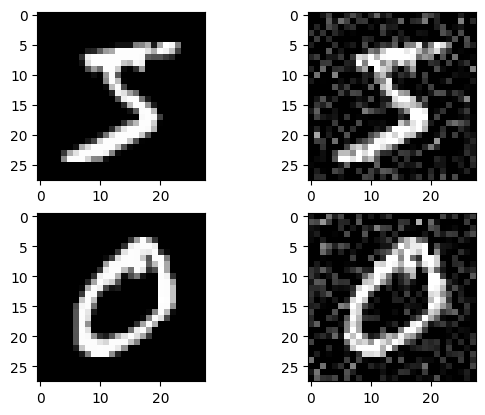

In [ ]:
# generating test augmentation
a= NoiseAugment(sigma=0.2, norm=False)
aug= a(Xtr[0:2])

f, axarr= plt.subplots(2, 2)

# original image - positive pair
axarr[0, 0].imshow(Xtr[0][0].cpu().detach().numpy(), cmap='gray')
axarr[0, 1].imshow(aug[0][0].detach().cpu().numpy(), cmap='gray')

# original image - positive pair
axarr[1, 0].imshow(Xtr[1][0].cpu().detach().numpy(), cmap='gray')
axarr[1, 1].imshow(aug[1][0].detach().cpu().numpy(), cmap='gray')
plt.show()

The noisy image X' can be obtained by adding the noise matrix N to the original image X, i.e., X' = X + N. The amount of noise added can be controlled by adjusting the value of sigma. For example, if sigma=0.1, then the noise added will be small and the resulting image will still be relatively clear. On the other hand, if sigma=1.0, then the noise added will be much larger and the resulting image will be much noisier.

After adding the noise, we use these corrupted images as input to the denoising autoencoder and the network is then trained to reconstruct the original, clean data from the noisy input by minimizing the difference between the reconstructed output and the clean input.

# Training the Denoising AE

In [ ]:
def d_autoencoder_training(model, learning_rate=1e-3, epochs=500, eval_interval=5, noise_level=0.1,
                           batches:bool=True, batch_size=64, shuffle:bool=True,
                           early_stop:bool=True, patience=5, cutoff=1e-9):

    # defining key hyperparamaters explicitly (instead of hyperparamater search)
    if batches:
        epoch_size= math.floor(Xtr.shape[0]/ batch_size)
    else:
        batch_size= Xtr.shape[0]
        epoch_size= 1

    weight_decay=5e-4

    # create a PyTorch optimizer
    optimizer= torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # loss function
    loss_fn= nn.BCELoss()

    # for decreasing learning rate -- the ReduceLROnPlateau is designed to be used per epoch
    scheduler= ReduceLROnPlateau(optimizer, mode="min", patience=5, factor=0.1, min_lr=1e-6)

    # data augmentation function
    augment_fn= NoiseAugment(sigma=noise_level)

    # for early stoping
    patience_count= 0
    previous_loss= 1e10

    # tracking statistics
    train_hist= []
    dev_hist= []
    schedule_hist= []

    # training data indexes
    ix= torch.arange(0, Xtr.shape[0])

    # --- training loop ---
    for epoch in tqdm(range(epochs)):

        batch_loss= []
        batch_schedule= []

        # iterating over all batches
        if shuffle:
            ix= torch.randperm(Xtr.shape[0])[:Xtr.shape[0]]

        for i in range(epoch_size):

            # --- minibatch construction ---
            Xmb= Xtr[ix[(i * batch_size) : ((i+1) * batch_size)]]
            # creating noise batches
            Xmb_noise= augment_fn(Xmb)

            # --- forward pass and get loss ---
            model.train(True)
            _, y_enc_dec= model(Xmb_noise)
            loss_tr= loss_fn(y_enc_dec, Xmb)
            batch_loss.append(loss_tr.item())

            # --- backward pass to calculate the gradients ---
            optimizer.zero_grad()
            loss_tr.backward()

            # --- update the parameters using the gradient ---
            optimizer.step()


        # --- evaluation and track stats ---
        train_hist.append(np.mean(batch_loss))

        if epoch% eval_interval== 0:
            model.train(False)
            with torch.no_grad():
                Xdev_noise= augment_fn(Xdev)
                _, y_enc_dec= model(Xdev_noise)
                loss_dev= loss_fn(y_enc_dec, Xdev)

        dev_hist.append(loss_dev.item())
        schedule_hist.append(scheduler.get_last_lr())
        scheduler.step(train_hist[-1]) # step learning rate scheduler


        # --- early stopping -- calculating loss change ---
        loss_change= np.abs(previous_loss - train_hist[-1])
        # deciding to stop if loss is not decreasing fast enough
        if (early_stop and loss_change< cutoff):
            patience_count += 1

            if patience_count> patience:
                print('\nEarly stopping at epoch {}'.format(epoch))
                model.train(False)
                break
        else:
            patience_count= 0
        # setting current train loss as previous loss
        previous_loss= train_hist[-1]


    return train_hist, dev_hist, schedule_hist


In [ ]:
# --- reseting the AE model for denoising training ---
dae_model= Autoencoder(embed_dim, image_size, input_chs, hidden_chs, output_chs,
                       kernels, paddings, max_pools).to(device)

dtrain_hist, ddev_hist, dschedule_hist= d_autoencoder_training(dae_model, learning_rate=1e-3, epochs=30,
                                                               noise_level=0.25, batch_size=250,
                                                               eval_interval=2, cutoff=1e-4)


100%|██████████| 30/30 [20:31<00:00, 41.06s/it]


0.0832749679684639


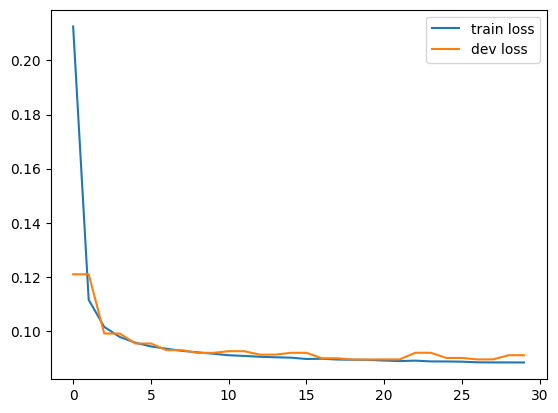

In [ ]:
# ploting
print(eval_autoencoder(dae_model, Xte, nn.BCELoss()))

plt.plot(dtrain_hist, label='train loss')
plt.plot(ddev_hist, label='dev loss')
plt.legend()
plt.show()

# Inferring the Denoising AE model

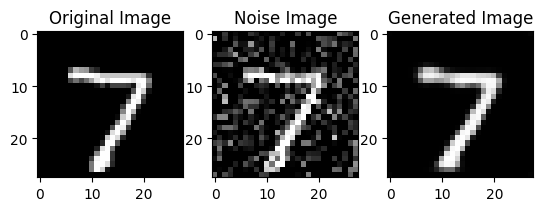

In [ ]:
# Select an image from the test set
img_index= 0
test_img= Xte[img_index:img_index+1]

a= NoiseAugment(sigma=0.25)
noise_img= a(test_img)

latent_vector, generated_img= dae_model(test_img)


# Plot the original image and the generated image
plt.subplot(1, 3, 1)
plt.imshow(test_img[0][0].cpu().detach().numpy(), cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(noise_img[0][0].cpu().detach().numpy(), cmap='gray')
plt.title('Noise Image')

plt.subplot(1, 3, 3)
plt.imshow(generated_img[0][0].cpu().detach().numpy(), cmap='gray')
plt.title('Generated Image')

plt.show()

In [ ]:
# https://medium.com/@ompramod9921/autoencoders-explained-9196c38af6f6
# https://pyimagesearch.com/2023/07/17/implementing-a-convolutional-autoencoder-with-pytorch/

# Variational Autoencoders (VAEs)

Variational Autoencoders (VAEs), which extend the capabilities of the traditional Autoencoder framework by incorporating probabilistic elements into the encoding process. VAEs introduce a probabilistic approach where the encoder outputs a distribution over the latent space, typically modeled as a multivariate Gaussian. This allows VAEs to sample from this distribution during the decoding process, leading to the generation of new data instances.

VAEs are part of a family of generative models that learn a probability distribution over the input data, allowing them to generate new samples that are similar to the training data. In essence, VAEs learn to model the underlying probability distribution of the input data, which allows them to generate new data points that are similar to the training data.

VAEs use a loss function that combines two terms: a reconstruction loss, which measures the ability of the decoder to reconstruct the input from the latent space, and a regularization term, which measures the divergence between the learned distribution and a prior distribution over the latent space. The regularization term is usually implemented using the Kullback-Leibler divergence, which measures the difference between two probability distributions.

Therefore, the key innovation of VAEs lies in their ability to generate new, high-quality data by learning a structured, continuous latent space. This is particularly important for generative modeling, where the goal is not just to compress data but to create new data samples that resemble the original dataset.

https://www.youtube.com/watch?v=ekyBklxwQMU 48:00min

In [12]:
class VAE(Autoencoder):
    """
    Define the Variational Autoencoder model.
    """

    def __init__(self, embed_dim, image_size, input_chs, hidden_chs, output_chs,
                 kernels=3, paddings=1, max_pools=2) -> None:
        super(VAE, self).__init__(embed_dim, image_size, input_chs, hidden_chs, output_chs,
                                  kernels, paddings, max_pools)
        # define mu and log(variance) layers for reparameterization
        self.mu     = nn.Linear(embed_dim, embed_dim)
        self.log_var= nn.Linear(embed_dim, embed_dim)


    def reparameterize(self, mu, log_var):
        # compute the standard deviation from the log(variance)
        std= torch.exp(0.5 * log_var)
        # generate random noise using the same shape as std
        gen_noise= torch.randn_like(std)

        return mu + std * gen_noise # return the reparameterized sample


    def forward(self, x):
        encoded= self.encode(x)
        mu= self.mu(encoded)                # compute the mean and log(variance) vectors
        log_var= self.log_var(encoded)
        z= self.reparameterize(mu, log_var) # reparameterize the latent variable
        decoded= self.decode(z)

        return encoded, decoded, mu, log_var


In [13]:
# --- VAE defs ---
embed_dim= 64
image_size= Xtr.shape[2]
input_chs= Xtr.shape[1]
hidden_chs= [32,64]
output_chs= 128
kernels= 3
paddings= 1
max_pools= 2

vae_model= VAE(embed_dim, image_size, input_chs, hidden_chs, output_chs,
               kernels, paddings, max_pools).to(device)

total_params= sum(p.numel() for p in vae_model.parameters() if p.requires_grad)
print(f'Number of parameters: {total_params}')

vae_model

Number of parameters: 489793


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (m_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (activ1): ReLU()
    (conv_hn): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (m_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (activ2): ReLU()
    (conv_out): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (m_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (activ3): ReLU()
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc_out): Linear(in_features=1152, out_features=64, bias=True)
  )
  (decoder): Decoder(
    (fc_in): Linear(in_features=64, out_features=1152, bias=True)
    (make2d): Unflatten(dim=1, unflattened_size=torch.Size([128, 3, 3]))
    (convT_in): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))


In [17]:
# Encode a sample image and decode its latent vector
y_en, y_dec, _, _= vae_model(Xtr[:1])
y_en.shape, y_dec.shape

(torch.Size([1, 64]), torch.Size([1, 1, 28, 28]))

# Reconstruction + KL Divergence Loss

In [ ]:
class KLD_Loss(nn.Module):
    """
    Reconstruction + KL divergence losses summed over all elements and batch
    see Appendix B from VAE paper:
    Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    https://arxiv.org/abs/1312.6114
    """

    def __init__(self, reduction='sum') -> None:
        super().__init__()
        self.reduction= reduction


    def forward(self, recon_x, true_x, mu, log_var):
        # BCE loss between the reconstructed output and the input data
        BCE= F.binary_cross_entropy(recon_x, true_x, reduction=self.reduction)
        # KLD between the learned latent variable distribution and a std Gaussian distribution
        KLD= -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        if self.reduction=='mean':
            KLD /= true_x.shape[0]

        return BCE + KLD  # combine the two losses by adding them together


# Training the VAE

In [ ]:
def vae_training(model, learning_rate=1e-3, epochs=500, eval_interval=5, batches:bool=True,
                 batch_size=64, shuffle:bool=True, early_stop:bool=True, patience=5, cutoff=1e-9):

    # defining key hyperparamaters explicitly (instead of hyperparamater search)
    if batches:
        epoch_size= math.floor(Xtr.shape[0]/ batch_size)
    else:
        batch_size= Xtr.shape[0]
        epoch_size= 1

    weight_decay=5e-4

    # create a PyTorch optimizer
    optimizer= torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # loss function
    loss_fn= KLD_Loss().forward

    # for decreasing learning rate -- the ReduceLROnPlateau is designed to be used per epoch
    scheduler= ReduceLROnPlateau(optimizer, mode="min", patience=5, factor=0.1, min_lr=1e-6)

    # for early stoping
    patience_count= 0
    previous_loss= 1e10

    # tracking statistics
    train_hist= []
    dev_hist= []
    schedule_hist= []

    # training data indexes
    ix= torch.arange(0, Xtr.shape[0])

    # --- training loop ---
    for epoch in tqdm(range(epochs)):

        batch_loss= []
        batch_schedule= []

        # iterating over all batches
        if shuffle:
            ix= torch.randperm(Xtr.shape[0])[:Xtr.shape[0]]

        for i in range(epoch_size):

            # --- minibatch construction ---
            Xmb= Xtr[ix[(i * batch_size) : ((i+1) * batch_size)]]

            # --- forward pass and get loss ---
            model.train(True)
            _, y_dec, mu, log_var= model(Xmb)
            loss_tr= loss_fn(y_dec, Xmb, mu, log_var)
            batch_loss.append(loss_tr.item() / Xmb.shape[0]) # KLD_Loss returns a sum by default

            # --- backward pass to calculate the gradients ---
            optimizer.zero_grad()
            loss_tr.backward()

            # --- update the parameters using the gradient ---
            optimizer.step()


        # --- evaluation and track stats ---
        train_hist.append(np.mean(batch_loss))

        if epoch% eval_interval== 0:
            model.train(False)
            with torch.no_grad():
                _, y_dec, mu, log_var= model(Xdev)
                loss_dev= loss_fn(y_dec, Xdev, mu, log_var)

        dev_hist.append(loss_dev.item() / Xdev.shape[0])
        schedule_hist.append(scheduler.get_last_lr())
        scheduler.step(train_hist[-1]) # step learning rate scheduler


        # --- early stopping -- calculating loss change ---
        loss_change= np.abs(previous_loss - train_hist[-1])
        # deciding to stop if loss is not decreasing fast enough
        if (early_stop and loss_change< cutoff):
            patience_count += 1

            if patience_count> patience:
                print('\nEarly stopping at epoch {}'.format(epoch))
                model.train(False)
                break
        else:
            patience_count= 0
        # setting current train loss as previous loss
        previous_loss= train_hist[-1]


    return train_hist, dev_hist, schedule_hist


In [ ]:
# --- VAE defs ---
embed_dim= 64
image_size= Xtr.shape[2]
input_chs= Xtr.shape[1]
hidden_chs= [32,64]
output_chs= 128
kernels= 3
paddings= 1
max_pools= 2

vae_model= VAE(embed_dim, image_size, input_chs, hidden_chs, output_chs,
               kernels, paddings, max_pools).to(device)

vae_train_hist, vae_dev_hist, vae_schedule_hist= vae_training(vae_model, learning_rate=1e-3, epochs=30,
                                                              eval_interval=2, batch_size=250,
                                                              cutoff=1e-4)


100%|██████████| 30/30 [20:20<00:00, 40.69s/it]


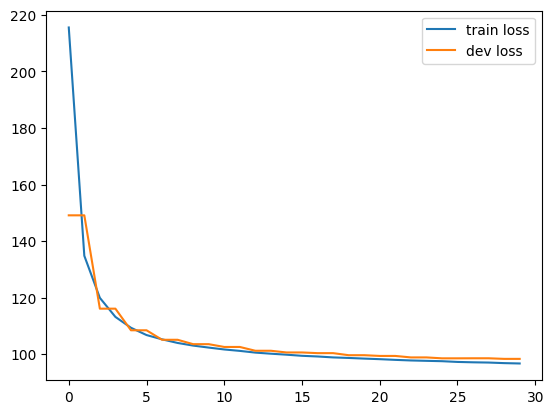

In [ ]:
# ploting
plt.plot(vae_train_hist, label='train loss')
plt.plot(vae_dev_hist, label='dev loss')
plt.legend()
plt.show()

# Inferring the VAE model

In [ ]:
def gen_samples(model, num_samples):
    model.train(False)
    with torch.no_grad():
        # generate random noise
        z= torch.randn(num_samples, model.embed_dim).to(device)
        samples= model.decode(z)

    return samples


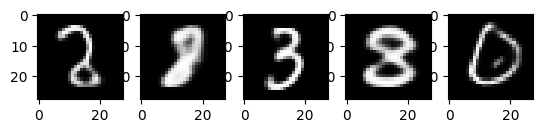

In [ ]:
samples= gen_samples(vae_model, 5)

f, axarr= plt.subplots(1, 5)

# original image - positive pair
for i in range(samples.shape[0]):
    axarr[i].imshow(samples[i][0].detach().cpu().numpy(), cmap='gray')

plt.show()

Variational Autoencoders (VAEs) have proven to be a groundbreaking advancement in the realm of machine learning and data generation.

While simple autoencoders can reconstruct images, they struggle with generating new data. Variational autoencoders (VAEs) offer a more flexible approach by learning parameters of a distribution of the latent space that can be sampled to generate new data. The re-parametrization trick is used to make the sampling operation differentiable. VAEs offer an improvement over simple autoencoders and have many applications, such as generative modelling, anomaly detection, and feature learning.

In [ ]:
# https://www.datacamp.com/tutorial/variational-autoencoders
# https://medium.com/@sofeikov/implementing-variational-autoencoders-from-scratch-533782d8eb95
# https://avandekleut.github.io/vae/

# Conditional Variational Autoencoders (CVAEs)

The C in CVAE stands for "conditional". This means that the encoder and decoder in addition to the input data (e.g. image for the encoder and latent vector for the decoder) are provided with an encoding for a condition. Therefore, the encoder does not need to represent the condition in the latent space since the decoder will also get this information as an extra input. Hence, the encoder can regress out the condition and learn e.g. the handwriting style as a latent representation.

In practice, conditions in CVAE models are commonly one-hot encoded. E.g. for the MNIST dataset with 10 different digits, we would use a size 10 vector. One-hot encodings work well, however, a trained model is limited to the conditions provided during training, due defined dimensions of the condition vector. If a CVAE model is trained on the MNSIT dataset for the digits 0-7 (using a size 8 one hot encoding), inference cannot be performed for digits 8 and 9.

**Using Learnable Conditional Embeddings:** These are unique vectors for each condition, but with values that will be updated in the training process. The model optimizer will update the embedding vectors together with all other model parameters to improve the loss during training. So we do not only have a latent space for images but also an embedding space for the conditions (digits). This means that we can add new digits to the model that were not included during training and the model might be able to infer the correct digit just with a new adjusted condition embedding.

In [14]:
class CVAE(nn.Module):
    """
    Define the Conditional Variational Autoencoder model.
    """

    def __init__(self, n_classes, cls_embed_dim, embed_dim, image_size, input_chs, hidden_chs,
                 output_chs, kernels=3, paddings=1, max_pools=2) -> None:
        super(CVAE, self).__init__()
        self.embed_dim= embed_dim
        # define the Learnable Conditional Embedding
        self.embed_cond= nn.Embedding(n_classes, cls_embed_dim, max_norm=True)
        # define mu and log(variance) layers
        self.mu   = nn.Linear(embed_dim, embed_dim)
        self.sigma= nn.Linear(embed_dim, embed_dim)

        # define the Conditional Variational Encoder-Decoder architecture
        self.encoder= Encoder(
            embed_dim, image_size, (input_chs+cls_embed_dim), hidden_chs, output_chs, kernels,
            paddings, max_pools
        )
        dec_input_chs= output_chs
        dec_hidden_chs= hidden_chs[::-1]
        dec_output_chs= input_chs
        dec_strides= max_pools

        self.decoder= Decoder(
            (embed_dim+cls_embed_dim), self.encoder.flat_size, dec_input_chs,
            dec_hidden_chs, dec_output_chs, kernels, paddings, dec_strides
        )


    def encode(self, x, y_emb):
        ones= torch.ones(x.shape, dtype=x.dtype, device=x.device)
        y= ones * y_emb.view(-1, y_emb.size(1), 1, 1)
        x= torch.cat((x, y), dim=1) # (batch_size, img_chs+cls_embed_dim, img_height, img_width)
        encoded= self.encoder(x)    # (batch_size, embed_dim)
        # outputs an encoded latent space
        return encoded


    def decode(self, z, y_emb):
        z= torch.cat((z, y_emb), dim=1) # (batch_size, embed_dim+cls_embed_dim)
        decoded= self.decoder(z)
        # outputs a decoded image from a latent space
        return decoded


    def reparameterize(self, mu, sigma):
        # compute the log(variance)
        sigma= torch.exp(0.5 * sigma)
        # generate a standard normal distribution
        n_dist= torch.distributions.Normal(0, 1)
        if mu.is_cuda:
            n_dist.loc  = n_dist.loc.cuda()  # hack to get sampling on the GPU
            n_dist.scale= n_dist.scale.cuda()

        return mu + sigma * n_dist.sample(mu.shape) # return the reparameterized sample


    def forward(self, x, y):
        # the labels are provided as variable y (non-one-hot vectors)
        y= self.embed_cond(y)             # (batch_size, cls_embed_dim)
        encoded= self.encode(x, y)        # (batch_size, embed_dim)
        # compute the mean and log(variance) vectors
        mu= self.mu(encoded)
        sigma= self.sigma(encoded)
        # sample a latent vector
        z= self.reparameterize(mu, sigma) # (batch_size, embed_dim)
        decoded= self.decode(z, y)        # (batch_size, img_chs, img_height, img_width)

        return encoded, decoded, mu, sigma


The model consists of an encoder and decoder (I adapted the model from the previous VAE). We first define the encoder, which takes as input the images and the conditional embedding and outputs a latent vector. The decoder is much simpler since it just uses a latent vector and the conditional embedding to infer images.

In [15]:
# --- CVAE defs ---
embed_dim= 64
n_classes= 10
cls_embed_dim= embed_dim
image_size= Xtr.shape[2]
input_chs= Xtr.shape[1]
hidden_chs= [32,64]
output_chs= 128
kernels= 3
paddings= 1
max_pools= 2

cvae_model= CVAE(n_classes, cls_embed_dim, embed_dim, image_size, input_chs, hidden_chs, output_chs,
                 kernels, paddings, max_pools).to(device)

# Encode a sample image and decode its latent vector
y_en, y_dec, _, _= cvae_model(Xtr[:1], torch.argmax(Ytr[:1], dim=1))
y_en.shape, y_dec.shape

(torch.Size([1, 64]), torch.Size([1, 1, 28, 28]))

**NOTE:** I am defining **cls_embed_dim** (the dimensionality of the Conditional Embedding **embed_cond**) with the same value of **embed_dim**, i.e., encoding 10 different labels using 64-dimensional vectors (in this example). It can be fine for encoding many labels (e.g., the 1000 ones in ImageNet) but is too much for this specific case (only 10 labels) and leads to a significant increase in the number of parameters of the CVAE model.

In [16]:
total_params= sum(p.numel() for p in cvae_model.parameters() if p.requires_grad)
print(f'Number of parameters: {total_params}')

cvae_model

Number of parameters: 582593


CVAE(
  (embed_cond): Embedding(10, 64, max_norm=True)
  (mu): Linear(in_features=64, out_features=64, bias=True)
  (sigma): Linear(in_features=64, out_features=64, bias=True)
  (encoder): Encoder(
    (conv_in): Conv2d(65, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (m_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (activ1): ReLU()
    (conv_hn): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (m_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (activ2): ReLU()
    (conv_out): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (m_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (activ3): ReLU()
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc_out): Linear(in_features=1152, out_features=64, bias=True)
  )
  (decoder): Decoder(
    (fc_in): Linear(in_features=128, out_features=1152, bias=True)
    (make2d): Un

# Training the CVAE

TODO: Training using data augmentation.

In [ ]:
# transforming labels back from one-hot vectors of length 10 to numbers as required by our CVAE
Ytr= torch.argmax(Ytr, dim=1)
Ydev= torch.argmax(Ydev, dim=1)

# training and dev data were not touched
print(f'Shape of training: Xtr - {Xtr.shape}, Ytr - {Ytr.shape}')
print(f'Shape of dev data: Xdev - {Xdev.shape}, Ydev - {Ydev.shape}')

Shape of training: Xtr - torch.Size([48000, 1, 28, 28]), Ytr - torch.Size([48000])
Shape of dev data: Xdev - torch.Size([12000, 1, 28, 28]), Ydev - torch.Size([12000])


In [ ]:
def cvae_training(model, learning_rate=1e-3, epochs=500, eval_interval=5, batches:bool=True,
                  batch_size=64, shuffle:bool=True, early_stop:bool=True, patience=5, cutoff=1e-9):

    # defining key hyperparamaters explicitly (instead of hyperparamater search)
    if batches:
        epoch_size= math.floor(Xtr.shape[0]/ batch_size)
    else:
        batch_size= Xtr.shape[0]
        epoch_size= 1

    weight_decay=5e-4

    # create a PyTorch optimizer
    optimizer= torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # loss function
    loss_fn= KLD_Loss().forward

    # for decreasing learning rate -- the ReduceLROnPlateau is designed to be used per epoch
    scheduler= ReduceLROnPlateau(optimizer, mode="min", patience=5, factor=0.1, min_lr=1e-6)

    # for early stoping
    patience_count= 0
    previous_loss= 1e10

    # tracking statistics
    train_hist= []
    dev_hist= []
    schedule_hist= []

    # training data indexes
    ix= torch.arange(0, Xtr.shape[0])

    # --- training loop ---
    for epoch in tqdm(range(epochs)):

        batch_loss= []
        batch_schedule= []

        # iterating over all batches
        if shuffle:
            ix= torch.randperm(Xtr.shape[0])[:Xtr.shape[0]]

        for i in range(epoch_size):

            # --- minibatch construction ---
            Xmb= Xtr[ix[(i * batch_size) : ((i+1) * batch_size)]]
            Ymb= Ytr[ix[(i * batch_size) : ((i+1) * batch_size)]]

            # --- forward pass and get loss ---
            model.train(True)
            _, y_dec, mu, sigma= model(Xmb, Ymb)
            loss_tr= loss_fn(y_dec, Xmb, mu, sigma)
            batch_loss.append(loss_tr.item() / Xmb.shape[0]) # KLD_Loss returns a sum by default

            # --- backward pass to calculate the gradients ---
            optimizer.zero_grad()
            loss_tr.backward()

            # --- update the parameters using the gradient ---
            optimizer.step()


        # --- evaluation and track stats ---
        train_hist.append(np.mean(batch_loss))

        if epoch% eval_interval== 0:
            model.train(False)
            with torch.no_grad():
                _, y_dec, mu, sigma= model(Xdev, Ydev)
                loss_dev= loss_fn(y_dec, Xdev, mu, sigma)

        dev_hist.append(loss_dev.item() / Xdev.shape[0])
        schedule_hist.append(scheduler.get_last_lr())
        scheduler.step(train_hist[-1]) # step learning rate scheduler


        # --- early stopping -- calculating loss change ---
        loss_change= np.abs(previous_loss - train_hist[-1])
        # deciding to stop if loss is not decreasing fast enough
        if (early_stop and loss_change< cutoff):
            patience_count += 1

            if patience_count> patience:
                print('\nEarly stopping at epoch {}'.format(epoch))
                model.train(False)
                break
        else:
            patience_count= 0
        # setting current train loss as previous loss
        previous_loss= train_hist[-1]


    return train_hist, dev_hist, schedule_hist


In [ ]:
# --- CVAE defs ---
embed_dim= 64
n_classes= 10
cls_embed_dim= embed_dim
image_size= Xtr.shape[2]
input_chs= Xtr.shape[1]
hidden_chs= [32,64]
output_chs= 128
kernels= 3
paddings= 1
max_pools= 2

cvae_model= CVAE(n_classes, cls_embed_dim, embed_dim, image_size, input_chs, hidden_chs, output_chs,
                 kernels, paddings, max_pools).to(device)

cvae_tr_hist, cvae_dev_hist, cvae_sched_hist= cvae_training(cvae_model, learning_rate=1e-3, epochs=30,
                                                            eval_interval=2, batch_size=250,
                                                            cutoff=1e-4)

100%|██████████| 30/30 [22:09<00:00, 44.31s/it]


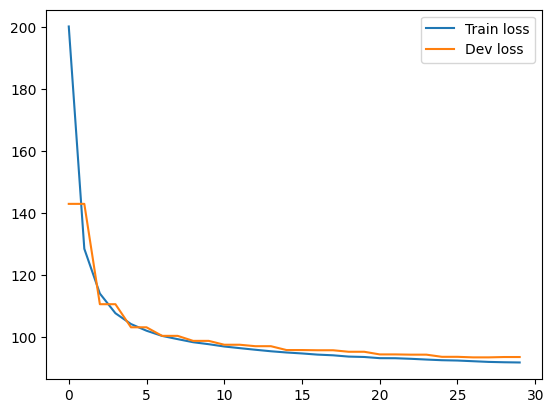

In [ ]:
# ploting
plt.plot(cvae_tr_hist, label='Train loss')
plt.plot(cvae_dev_hist, label='Dev loss')
plt.legend()
plt.show()

# Inferring the CVAE model

We can visually check how well the model is able to generate digits from the latent space. To do so, we create a grid in the latent space and letting the decoder generate images of the digits we are interested in. Since we only used a 2-dimensional latent space, we can use a 2D grid.

In [ ]:
def plot_reconstructed_cvae(model, target=2, grid=8, r0=(-3,3), r1=(-3,3),
                            device='cuda'):
    # define plot array
    fig, ax= plt.subplots(grid, grid)

    # loop over a grid in the latent space
    for i, a in enumerate(torch.linspace(*r1, grid)):
        for j, b in enumerate(torch.linspace(*r0, grid)):
            model.train(False)
            with torch.no_grad():
                z= torch.linspace(a, b, steps=model.embed_dim, device=device).view(1, model.embed_dim)
                y_emb= model.embed_cond(torch.tensor([target]).to(device))
                # forwardig the data through the decoder
                x_hat= model.decode(z, y_emb)

                x_hat= x_hat.reshape(x_hat.size(-2), x_hat.size(-1)).detach().cpu().numpy()
                ax[i, j].imshow(x_hat, cmap='gray')
                ax[i, j].axis('off')

    plt.show()


Especially in the center of the latent space, the digits are very clear. Overall, the decoder is able to generate readable images of handwritten digits for all the provided numbers during training.

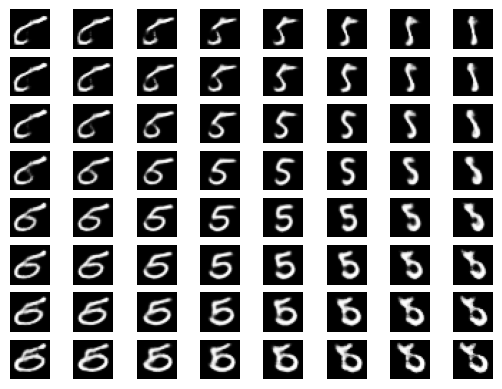

In [ ]:
plot_reconstructed_cvae(cvae_model, target=5, device=device)

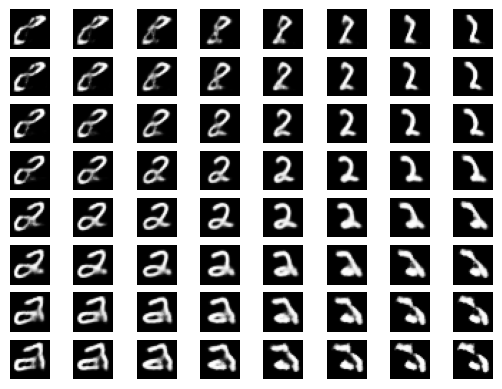

In [ ]:
plot_reconstructed_cvae(cvae_model, target=2, device=device)

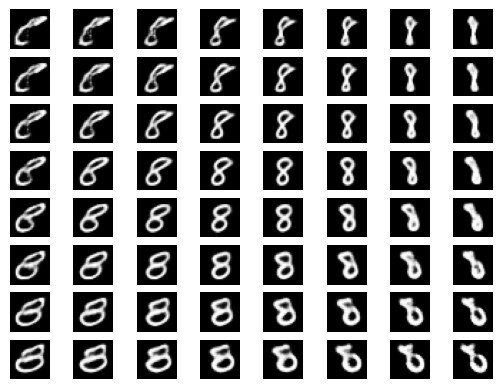

In [ ]:
plot_reconstructed_cvae(cvae_model, target=8, device=device)

In [ ]:
""" CVAEs with learnable conditional embeddings """
# https://towardsdatascience.com/conditional-variational-autoencoders-with-learnable-conditional-embeddings-e22ee5359a2a

In [ ]:
# https://towardsdatascience.com/understanding-conditional-variational-autoencoders-cd62b4f57bf8
# https://github.com/debtanu177/CVAE_MNIST/blob/master/train_cvae.py
# https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/autoencoder/ae-cnn-cvae.ipynb